In [2]:
import os

import pytesseract
from pytesseract import Output
import cv2

# Libraries for Visualization
from PIL import Image, ImageDraw
from IPython.display import display

In [3]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

In [7]:
class Wordbox:
    def __init__(self, level, page_num, block_num, par_num, line_num, word_num, left, top, width, height, conf, text):
        self.level = level
        self.page_num = page_num
        self.block_num = block_num
        self.par_num = par_num
        self.line_num = line_num
        self.word_num = word_num
        self.left = left
        self.top = top
        self.width = width
        self.height = height
        self.conf = conf
        self.text = text
        self.neighs = {}
        
    def set_neighs(self, left=None, right=None, top=None, bottom=None):
        if left is not None:
            self.neighs['left'] = left
        if right is not None:
            self.neighs['right'] = right
        if top is not None:
            self.neighs['top'] = top
        if bottom is not None:
            self.neighs['bottom'] = bottom
        pass
        
    def __str__(self):
        def get_neigh(key):
            if key in self.neighs:
                return self.neighs[key].text
            return 'None'
        return 'text: ' + self.text + ' | left=' + get_neigh('left') + ' | right=' + get_neigh('right') + ' | top=' + get_neigh('top') + ' | bottom=' + get_neigh('bottom')

In [8]:
import re
def isValid(text):
    if len(text.strip()) == 0:
        return False
    if re.match(r'[:;,.!?\\-]', text.strip()) is not None:
        return False
    return True

In [9]:
kWidthThreshold = 2.0

def task1(path, output_file=None):
    print('Process: ' + path)
    img = cv2.imread(path)
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    n_boxes = len(d['level'])

    wordboxes = []
    for i in range(n_boxes):
        if d['level'][i] == 5:
            wordboxes.append(Wordbox(d['level'][i], d['page_num'][i], d['block_num'][i], d['par_num'][i], d['line_num'][i], d['word_num'][i], d['left'][i], d['top'][i], d['width'][i], d['height'][i], d['conf'][i], d['text'][i]))

    for i in range(n_boxes):
        if d['level'][i] == 5:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

    wordboxes = list(filter(lambda x: isValid(x.text), wordboxes))
    wordboxes = sorted(wordboxes, key=lambda x:(x.page_num, x.block_num, x.par_num, x.line_num, x.left))        

    curr_left, curr_top, curr_right, curr_bottom, curr_pos, curr_word = None, None, None, None, None, None

    ret = ''
    args = [-1] * 11 + [""]
    wordboxes.append(Wordbox(*args))
    new_wordboxes = []
    state = None
    curr_line_num = None
    acc_num_letters = 0
    acc_width = 0
    for wordbox in wordboxes:
        new_pos = (wordbox.page_num, wordbox.block_num, wordbox.par_num, wordbox.line_num)
        # Different? Then update the current line number and its state.
        if new_pos != curr_pos:
            acc_num_letters = 0
            acc_width = 0
            
        # Aggregate.
        acc_num_letters += len(wordbox.text.strip())
        acc_width += wordbox.width
            
        hasMerged = False
        if new_pos == curr_pos:
            # Computer the letter weight.
            letter_weight = acc_width / acc_num_letters
            
            # Should we merged?
            if (wordbox.left - curr_right) / letter_weight <= kWidthThreshold:
                curr_right = wordbox.left + wordbox.width
                curr_word = curr_word + ' ' + wordbox.text
                hasMerged = True
        # No, then create a new wordbox.
        if not hasMerged:
            if curr_pos is not None:
                assert state is not None
                if isValid(curr_word):
                    new_wordboxes.append(Wordbox(
                        6,
                        page_num=state['page_num'],
                        block_num=state['block_num'],
                        par_num=state['par_num'],
                        line_num=state['line_num'],
                        word_num=-1,
                        left=curr_left,
                        top=curr_top,
                        width=curr_right - curr_left,
                        height=curr_bottom - curr_top,
                        conf=-1,
                        text=curr_word
                    ))
            curr_word = wordbox.text
            curr_pos = new_pos
            curr_left = wordbox.left
            curr_top = wordbox.top
            curr_right = wordbox.left + wordbox.width
            curr_bottom = wordbox.top + wordbox.height
            
            # Update the state.
            state = {
                'page_num' : wordbox.page_num,
                'block_num' : wordbox.block_num,
                'par_num' : wordbox.par_num,
                'line_num' : wordbox.line_num
            }
    # Return the updated wordboxes.
    return new_wordboxes

In [10]:
def debug(index):
    box = boxes[index]
    return (box.page_num, box.block_num, box.par_num, box.line_num)

def info(box):
    return str((box.text, box.left, box.top, box.width, box.height))

def gravityCenter(box):
# Compute the gravity center of `box`.
    return (box.left + box.width / 2, box.top + box.height / 2)

def isHorizontal(this, other):
# Check whether `other` is placed horizontally wrt to `this`.
    if this.top >= other.top + other.height:
        return False
    if other.top >= this.top + this.height:
        return False
    return True

def isVertical(this, other):
# Check whether `other` is placed vertically wrt to `this`.
    if this.left >= other.left + other.width:
        return False
    if other.left >= this.left + this.width:
        return False
    return True

def coordDiff(this, other, axis):
# Coordinate difference on `axis`.
    return abs(gravityCenter(this)[axis] - gravityCenter(other)[axis])

def isHCloser(this, other, that):
# Is `other` horizontally closer than `that` wrt `this`?
    return coordDiff(this, other, 0) <= coordDiff(this, that, 0) 

def isVCloser(this, other, that):
# Is `other` vertically closer than `that` wrt `this`?
    return coordDiff(this, other, 1) <= coordDiff(this, that, 1) 

def isLeft(this, other):
# Left?
    return isHorizontal(this, other) and gravityCenter(this)[0] >= gravityCenter(other)[0]

def isRight(this, other):
# Right?
    return isHorizontal(this, other) and gravityCenter(this)[0] <= gravityCenter(other)[0]

def isTop(this, other):
# Top?
    return isVertical(this, other) and gravityCenter(this)[1] >= gravityCenter(other)[1]

def isBottom(this, other):
# Bottom?
    return isVertical(this, other) and gravityCenter(this)[1] <= gravityCenter(other)[1]

# Function mapper.
mapper = {'left': {'direction_fn' : isLeft, 'closer_fn' : isHCloser},
          'right' : {'direction_fn' : isRight, 'closer_fn' : isHCloser},
          'top' : {'direction_fn' : isTop, 'closer_fn' : isVCloser},
          'bottom' : {'direction_fn' : isBottom, 'closer_fn' : isVCloser}
         }

# Update the neighbors.
def update(coord, this, other):
    for key in coord.keys():
        if mapper[key]['direction_fn'](this, other):
            if (coord[key] is None) or (mapper[key]['closer_fn'](this, other, coord[key])):
                coord[key] = other

# Print the graph.
# TODO: visualize graph
# print('\n'.join([str(elem) for elem in boxes]))

In [11]:
# Construct the graph.
def construct_graph(filepath):
    boxes = task1('img/test.jpg', 'output/test.txt')

    graph = {}
    for i, box1 in enumerate(boxes):
        coord = {'left' : None, 'right' : None, 'top' : None, 'bottom' : None}
        for j, box2 in enumerate(boxes):
            if i == j:
                continue
            update(coord, box1, box2)
        # Set the neighbors.
        box1.set_neighs(left=coord['left'], right=coord['right'], top=coord['top'], bottom=coord['bottom'])

    return boxes

In [12]:
def annotate_image(filepath, boxes):
    kWidth = 2
    kBoxColor = (0, 0, 255, 255)
    with Image.open(filepath).convert('RGBA') as img:
        draw = ImageDraw.Draw(img)
    
        for box in boxes:
            top, bottom, left, right = box.top, box.top + box.height, box.left, box.left + box.width
            # Top, Bottom, Left, Right Lines
            draw.line((left, top, right, top), width=kWidth, fill=kBoxColor)
            draw.line((left, bottom, right, bottom), width=kWidth, fill=kBoxColor)
            draw.line((left, top, left, bottom), width=kWidth, fill=kBoxColor)
            draw.line((right, top, right, bottom), width=kWidth, fill=kBoxColor)
    
        display(img)

Process: ./img/test.jpg


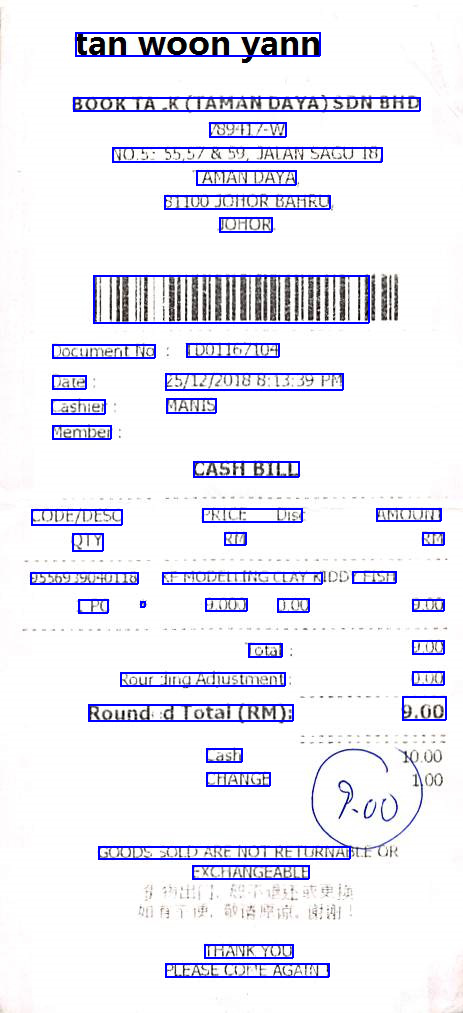

In [14]:
def construct_annotated_graph(filepath):
    boxes = task1(filepath)
    annotate_image(filepath, boxes)

construct_annotated_graph('./img/test.jpg')